# Import Libraries

In [ ]:
!pip -q install catboost
!pip -q install -U xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.8 MB/s eta 0:00:00


In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from prophet.serialize import model_to_json
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and Inspect Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/LEARN/AI/Data Model/Final Project/combined_pm25_dataset.csv")
df_forecast = pd.read_csv("/content/drive/MyDrive/LEARN/AI/Data Model/Final Project/combined_pm25_39T_forecast_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df['pm25'].interpolate(method='linear', inplace=True) # handle missing values

df.shape

(2192, 53)

# Feature Engineering

In [ ]:
def create_features(df):
    df = df.copy()

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

    # Calendar features
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Seasonal features
    df['season'] = pd.cut(
        df.index.month,
        bins=[0, 2, 5, 10, 12],
        labels=['Cool', 'Summer', 'Rainy', 'Cool'],
        ordered=False
    )

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['dayofyear']/365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['dayofyear']/365)

    # Lagged and rolling features for pm25
    for lag in [1, 2, 3, 7, 14, 21, 30]:
        df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)
    for window in [7, 14, 30]:
        df[f'pm25_rolling_mean_{window}'] = df['pm25'].rolling(window=window).mean()
        df[f'pm25_rolling_std_{window}'] = df['pm25'].rolling(window=window).std()
        df[f'pm25_rolling_max_{window}'] = df['pm25'].rolling(window=window).max()
        df[f'pm25_rolling_min_{window}'] = df['pm25'].rolling(window=window).min()

    # Lagged and rolling for important variables
    important_cols = [
        'fire_count_total',
        'relative_humidity_2m_mean (%)',
        'temperature_2m_mean (°C)_center',
        'precipitation_sum (mm)_center',
        'cloud_cover_mean (%)'
    ]
    for col in important_cols:
        for lag in [1, 3, 7, 14]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        for window in [7, 14]:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

    # Expanding features
    df['pm25_expanding_mean'] = df['pm25'].expanding().mean()
    df['fire_count_expanding_sum'] = df['fire_count_total'].expanding().sum()

    # Diff features
    df['pm25_diff_1'] = df['pm25'].diff(1)
    df['temperature_diff_1'] = df['temperature_2m_mean (°C)_center'].diff(1)
    df['humidity_diff_1'] = df['relative_humidity_2m_mean (%)'].diff(1)

    # Aggregate features across regions
    df['temperature_mean_all_regions'] = df[[
        'temperature_2m_mean (°C)_north',
        'temperature_2m_mean (°C)_south',
        'temperature_2m_mean (°C)_east',
        'temperature_2m_mean (°C)_west'
    ]].mean(axis=1)

    df['precipitation_sum_all_regions'] = df[[
        'precipitation_sum (mm)_north',
        'precipitation_sum (mm)_south',
        'precipitation_sum (mm)_east',
        'precipitation_sum (mm)_west'
    ]].sum(axis=1)

    # Wind direction decomposition
    df['wind_x'] = np.cos(np.radians(df['winddirection_10m_dominant (°)']))
    df['wind_y'] = np.sin(np.radians(df['winddirection_10m_dominant (°)']))

    # Weather code encoding (example: rainy indicator)
    rainy_codes = [51, 61, 63, 65]  # Adjust codes according to WMO definition
    df['is_rainy_weather'] = df['weather_code (wmo code)'].isin(rainy_codes).astype(int)

    # Interaction features
    df['temp_humidity'] = df['temperature_2m_mean (°C)_center'] * df['relative_humidity_2m_mean (%)']
    df['wind_temp'] = df['wind_speed_10m_mean (km/h)'] * df['temperature_2m_mean (°C)_center']
    df['fire_temp'] = df['fire_count_total'] * df['temperature_2m_mean (°C)_center']
    df['fire_humidity'] = df['fire_count_total'] * df['relative_humidity_2m_mean (%)']

    # Binary thresholds
    df['is_march'] = (df.index.month == 3).astype(int)
    df['is_dry_season'] = df['season'].isin(['Cool', 'Summer']).astype(int)
    df['is_burning_season'] = df.index.month.isin([1, 2, 3, 4]).astype(int)
    df['is_high_temp'] = (df['temperature_2m_mean (°C)_center'] > 33).astype(int)
    df['is_low_humidity'] = (df['relative_humidity_2m_mean (%)'] < 55).astype(int)

    # Moving average of lagged targets
    df['pm25_lag_1_3_mean'] = (df['pm25'].shift(1) + df['pm25'].shift(2) + df['pm25'].shift(3)) / 3

    # encode season
    df['season'] = df['season'].map({'Cool': 0, 'Summer': 1, 'Rainy': 2, 'Cool': 3})

    # Handle missing values
    for col in df.columns:
        if df[col].dtype != 'object' and df[col].dtype != 'category':
            df[col] = df[col].fillna(df[col].mean())

    return df

In [ ]:
df_features = create_features(df)
df_forecast_features = create_features(df_forecast)

In [ ]:
df_features.shape

(2192, 145)

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.inspection import permutation_importance

def select_features(X, y, method='hybrid', n_features=None, threshold=None):
    feature_names = X.columns.tolist()
    importances = {}

    # 1. Correlation Analysis (Filter Method)
    if method in ['correlation', 'hybrid']:
        print('Process correlation method ...')
        # ใช้ Spearman correlation เพราะไม่มีข้อสมมติเรื่องการกระจายแบบปกติ
        corr = np.abs(pd.DataFrame({'target': y}).join(X).corr(method='spearman')['target'])
        corr = corr.drop('target')
        importances['correlation'] = corr

    # 2. Mutual Information (Filter Method ที่จับความสัมพันธ์ไม่เชิงเส้น)
    if method in ['mutual_info', 'hybrid']:
        print('Process mutual_info method ...')
        mi = mutual_info_regression(X, y)
        mi_scores = pd.Series(mi, index=feature_names)
        importances['mutual_info'] = mi_scores

    # 3. Random Forest Feature Importance (Embedded Method)
    if method in ['rf', 'hybrid']:
        print('Process rf method ...')
        # ใช้ parameters ที่ไม่ใช้เวลามากเกินไป
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        rf_importances = pd.Series(rf.feature_importances_, index=feature_names)
        importances['random_forest'] = rf_importances

        print('Sub process Permutation Importance')
        # Permutation Importance (ให้ผลที่น่าเชื่อถือกว่า feature_importances_)
        perm_importance = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importances = pd.Series(perm_importance.importances_mean, index=feature_names)
        importances['permutation'] = perm_importances

    # 4. CatBoost Feature Importance (Embedded Method ที่มีประสิทธิภาพสูง)
    if method in ['xgboost', 'hybrid']:
        print('Process XGBoost method ...')
        xgb = XGBRegressor(
            random_seed=42,
            verbose=False,
            enable_categorical=True,
            n_jobs=-1
        )
        xgb.fit(X, y)
        xgb_importances = pd.Series(xgb.feature_importances_, index=feature_names)
        importances['xgboost'] = xgb_importances

    # รวม scores จากทุกวิธี (สำหรับ hybrid method)
    if method == 'hybrid':
        print('Process hybrid method ...')
        # สร้าง rank สำหรับแต่ละวิธี (1 = สำคัญที่สุด)
        ranks = {}
        for name, importance in importances.items():
            ranks[name] = importance.rank(ascending=False)

        # คำนวณ average rank
        avg_rank = pd.DataFrame(ranks).mean(axis=1)
        final_importance = 1 / avg_rank  # แปลงให้ค่าสูง = สำคัญมาก
        importances['hybrid'] = final_importance

        # เลือกค่าความสำคัญที่จะใช้ตัดสินใจ
        selected_importance = final_importance
    else:
        selected_importance = importances[method]

    # เลือก features ตามจำนวนหรือ threshold
    if n_features is not None:
        selected_features = selected_importance.nlargest(n_features).index.tolist()
    elif threshold is not None:
        max_importance = selected_importance.max()
        selected_features = selected_importance[selected_importance >= max_importance * threshold].index.tolist()
    else:
        # ถ้าไม่ระบุ n_features หรือ threshold ให้ใช้ค่า default
        selected_features = selected_importance.nlargest(min(15, len(feature_names))).index.tolist()

    return selected_features, importances

In [ ]:
selected_features, importances = select_features(
    df_features.drop(['pm25'], axis=1), df_features['pm25'],
    method='hybrid',
    n_features=40
)

Process correlation method ...
Process mutual_info method ...
Process rf method ...
Sub process Permutation Importance
Process XGBoost method ...
Process hybrid method ...


In [ ]:
selected_columns = selected_features + ['pm25', 'month', 'day', 'day_of_week', 'quarter', 'year', 'dayofyear', 'season']

df_selected_features = df_features[selected_columns]
df_selected_features_forecast = df_forecast_features[selected_columns]

# Prepare Dataset

In [ ]:
train_end = '2022-12-31'
val_end = '2023-12-31'

In [ ]:
df_train = df_selected_features[:train_end]
df_val = df_selected_features_forecast[train_end:val_end] # forecast
df_test = df_selected_features_forecast[val_end:] # forecast

In [ ]:
print(f"Training set: {df_train.shape}")
print(f"Validation set: {df_val.shape}")
print(f"Test set: {df_test.shape}")

Training set: (1461, 48)
Validation set: (365, 48)
Test set: (367, 48)


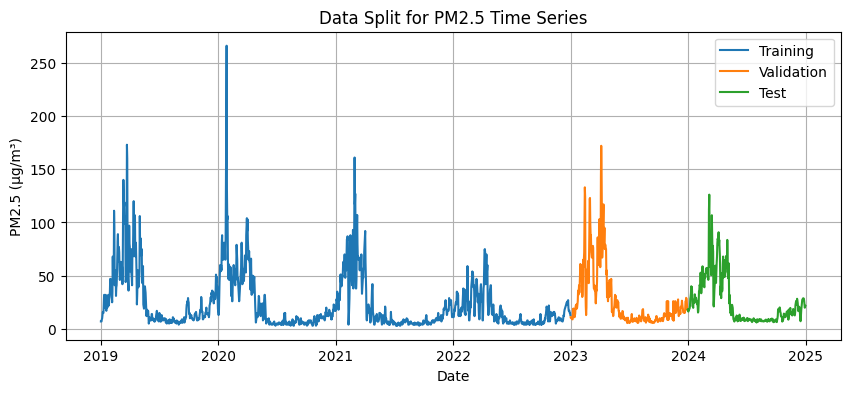

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_train.index, df_train['pm25'], label='Training')
plt.plot(df_val.index, df_val['pm25'], label='Validation')
plt.plot(df_test.index, df_test['pm25'], label='Test')
plt.title('Data Split for PM2.5 Time Series')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Prepare base data

In [ ]:
def create_X_y(df, target_col='pm25', drop_cols=None):
    if drop_cols is None:
        drop_cols = ['pm25']  # At minimum, drop the target
    else:
        drop_cols = drop_cols + [target_col]

    X = df.drop(columns=drop_cols)
    y = df[target_col]

    return X, y

In [ ]:
drop_cols = ['month', 'day', 'day_of_week', 'quarter', 'year', 'dayofyear', 'season']
# drop_cols = None

X_train, y_train = create_X_y(df_train, drop_cols=drop_cols)
X_val, y_val = create_X_y(df_val, drop_cols=drop_cols)
X_test, y_test = create_X_y(df_test, drop_cols=drop_cols)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_val shape: {X_val_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")

X_train shape: (1461, 40)
X_val shape: (365, 40)
X_test shape: (367, 40)


## Prepare LSTM data

In [ ]:
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

In [ ]:
seq_length = 30

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_length)

In [ ]:
print(f"LSTM training data shape: {X_train_seq.shape}")
print(f"LSTM validation data shape: {X_val_seq.shape}")
print(f"LSTM test data shape: {X_test_seq.shape}")

LSTM training data shape: (1431, 30, 40)
LSTM validation data shape: (335, 30, 40)
LSTM test data shape: (337, 30, 40)


# Modeling

## LSTM model (baseline)

In [ ]:
def build_lstm_model(input_shape):
    """
    Build LSTM model for PM2.5 forecasting.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(32)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae')
    return model

In [ ]:
lstm_model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

In [ ]:
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - loss: 23.8015 - val_loss: 27.6860 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 24.0777 - val_loss: 27.5053 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 23.6043 - val_loss: 27.1882 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 22.1293 - val_loss: 26.1633 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 20.6838 - val_loss: 23.6504 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 21.0395 - val_loss: 22.5178 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 19.4171 - val_loss: 21.8755 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 17.2235 - val_loss: 20.2969 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 15.0341 - val_loss: 19.6972 - learning_r

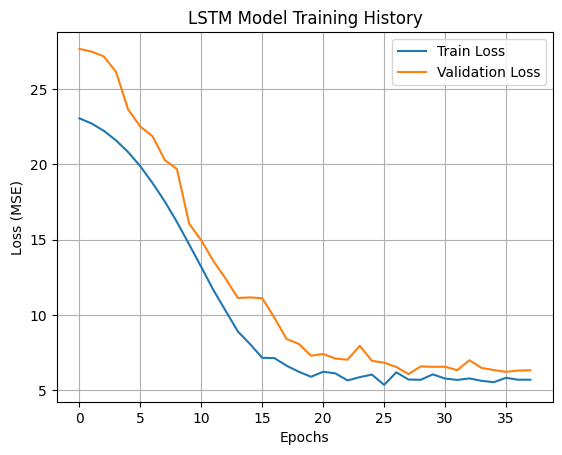

In [ ]:
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [377]:
lstm_val_preds = lstm_model.predict(X_val_seq).flatten()
lstm_test_preds = lstm_model.predict(X_test_seq).flatten()

lstm_val_rmse = np.sqrt(mean_squared_error(y_val_seq, lstm_val_preds))
lstm_val_mae = mean_absolute_error(y_val_seq, lstm_val_preds)
lstm_val_mape = mean_absolute_percentage_error(y_val_seq, lstm_val_preds) * 100

print(f"LSTM Validation RMSE: {lstm_val_rmse:.2f}")
print(f"LSTM Validation MAE: {lstm_val_mae:.2f}")
print(f"LSTM Validation MAPE: {lstm_val_mape:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
LSTM Validation RMSE: 10.98
LSTM Validation MAE: 6.05
LSTM Validation MAPE: 21.94%


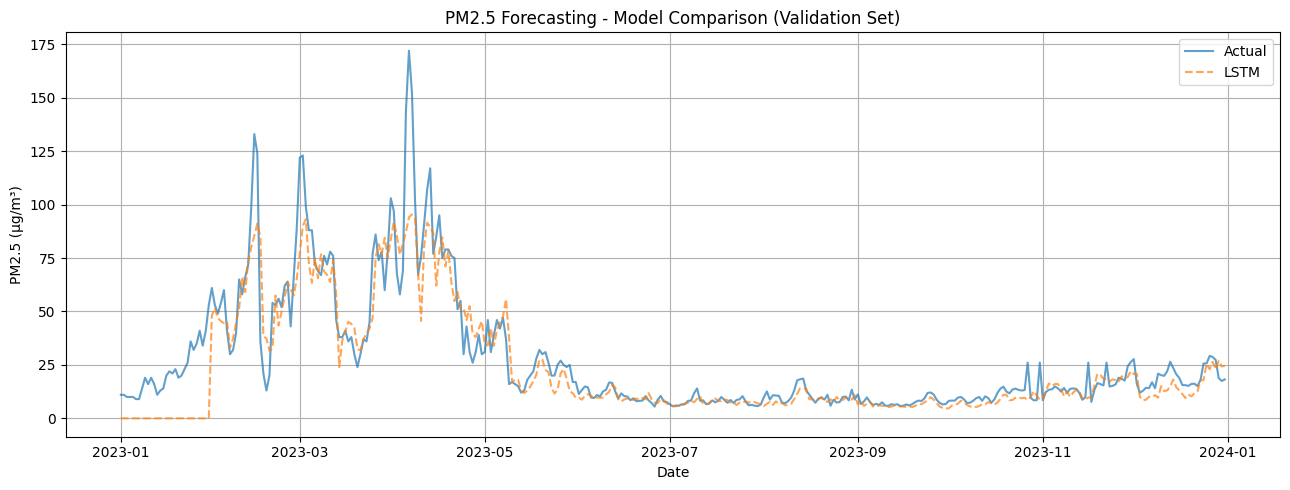

In [ ]:
val_dates = df_val.index

plt.figure(figsize=(13, 5))
plt.plot(val_dates, y_val, label='Actual', alpha=0.7)
plt.plot(val_dates[:len(np.concat([np.zeros((30, )), lstm_val_preds]))], np.concat([np.zeros((30, )), lstm_val_preds]), label='LSTM', linestyle='--', alpha=0.7)
plt.title('PM2.5 Forecasting - Model Comparison (Validation Set)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Prophet + Boosting hybrid models (Proposed)

In [299]:
prophet_df = pd.DataFrame({
    'ds': df.index,
    'y': df['pm25']
})

In [300]:
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7mcar4st/idyxyozl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7mcar4st/1gkmbuv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98677', 'data', 'file=/tmp/tmp7mcar4st/idyxyozl.json', 'init=/tmp/tmp7mcar4st/1gkmbuv3.json', 'output', 'file=/tmp/tmp7mcar4st/prophet_modely2swduuq/prophet_model-20250429040234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:02:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [301]:
prophet_forecast = prophet_model.predict(pd.DataFrame({'ds': df.index}))
prophet_forecast['actual'] = df['pm25'].values
prophet_forecast['residuals'] = prophet_forecast['actual'] - prophet_forecast['yhat']

In [302]:
df_features_with_prophet = pd.concat([df_selected_features[:train_end], df_selected_features_forecast[train_end:]])
df_features_with_prophet['prophet_pred'] = prophet_forecast['yhat'].values
df_features_with_prophet['prophet_trend'] = prophet_forecast['trend'].values
df_features_with_prophet['prophet_residuals'] = prophet_forecast['residuals'].values

In [304]:
df_train_with_prophet = df_features_with_prophet[:train_end]
df_val_with_prophet = df_features_with_prophet[train_end:val_end].drop(['2022-12-31'])
df_test_with_prophet = df_features_with_prophet[val_end:].drop(['2023-12-31'])

In [305]:
drop_cols_boost = ['month', 'day', 'day_of_week', 'pm25', 'prophet_residuals', 'prophet_pred']

X_train_boost, y_train_boost = create_X_y(df_train_with_prophet, target_col='prophet_residuals', drop_cols=drop_cols_boost)
X_val_boost, y_val_boost = create_X_y(df_val_with_prophet, target_col='prophet_residuals', drop_cols=drop_cols_boost)
X_test_boost, y_test_boost = create_X_y(df_test_with_prophet, target_col='prophet_residuals', drop_cols=drop_cols_boost)

### Train residual models

In [292]:
xgb_model = XGBRegressor(
    enable_categorical=True,
    random_state=42
)

xgb_model.fit(
    X_train_boost, y_train_boost,
    eval_set=[(X_val_boost, y_val_boost)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [293]:
catboost_model = CatBoostRegressor(
    random_seed=42,
    verbose=False
)

catboost_model.fit(
    X_train_boost, y_train_boost,
    eval_set=[(X_val_boost, y_val_boost)],
    cat_features=['season'],
    verbose=False
)

In [294]:
lgbm_model = LGBMRegressor(
    verbosity=-1,
    random_state=42
)

lgbm_model.fit(
    X_train_boost, y_train_boost,
    eval_set=[(X_val_boost, y_val_boost)],
)

LGBMRegressor(random_state=42, verbosity=-1)

### Make hybrid predictions

In [295]:
prophet_val_preds = df_val_with_prophet['prophet_pred'].values

xgb_val_residual_preds = xgb_model.predict(X_val_boost)
hybrid_xgb_preds = prophet_val_preds + xgb_val_residual_preds

catboost_val_residual_preds = catboost_model.predict(X_val_boost)
hybrid_cat_preds = prophet_val_preds + catboost_val_residual_preds

lgbm_val_residual_preds = lgbm_model.predict(X_val_boost)
hybrid_lgbm_preds = prophet_val_preds + lgbm_val_residual_preds

In [ ]:
catboost_val_residual_preds

In [297]:
hybrid_xgb_rmse = np.sqrt(mean_squared_error(y_val, hybrid_xgb_preds))
hybrid_cat_rmse = np.sqrt(mean_squared_error(y_val, hybrid_cat_preds))
hybrid_lgbm_rmse = np.sqrt(mean_squared_error(y_val, hybrid_lgbm_preds))

hybrid_xgb_mape = mean_absolute_percentage_error(y_val, hybrid_xgb_preds) * 100
hybrid_cat_mape = mean_absolute_percentage_error(y_val, hybrid_cat_preds) * 100
hybrid_lgbm_mape = mean_absolute_percentage_error(y_val, hybrid_lgbm_preds) * 100

print("\nHybrid Model Comparison (Validation Set):")
print(f"Prophet + XGBoost RMSE: {hybrid_xgb_rmse:.2f}, MAPE: {hybrid_xgb_mape:.2f}%")
print(f"Prophet + CatBoost RMSE: {hybrid_cat_rmse:.2f}, MAPE: {hybrid_cat_mape:.2f}%")
print(f"Prophet + LightGBM RMSE: {hybrid_lgbm_rmse:.2f}, MAPE: {hybrid_lgbm_mape:.2f}%")


Hybrid Model Comparison (Validation Set):
Prophet + XGBoost RMSE: 8.09, MAPE: 22.12%
Prophet + CatBoost RMSE: 5.97, MAPE: 15.56%
Prophet + LightGBM RMSE: 9.08, MAPE: 28.18%


### Tune residual model

In [ ]:
param_grid_cat = {
    'iterations': [100, 300, 500],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bylevel': [0.7, 0.8, 0.9],
    'l2_leaf_reg': [1, 3, 5]
}

In [323]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

cat_base = CatBoostRegressor(
    random_state=42,
    early_stopping_rounds=50,
    verbose=False
)

search_cat = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=param_grid_cat,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [166]:
search_cat.fit(X_train_boost, y_train_boost, cat_features=['season'])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7b0fef9bcc10>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.7, 0.8, 0.9],
                                        'depth': [3, 5, 7],
                                        'iterations': [100, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [168]:
print(f"Best parameters: {search_cat.best_params_}")
print(f"Best score: {-search_cat.best_score_:.4f} (MSE)")

Best parameters: {'subsample': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 3, 'colsample_bylevel': 0.7}
Best score: 92.7169 (MSE)


In [169]:
optimized_cat = CatBoostRegressor(**search_cat.best_params_, random_state=42)
optimized_cat.fit(X_train_boost, y_train_boost, cat_features=['season'], verbose=False)

# Make predictions with optimized model
cat_val_residual_preds_opt = optimized_cat.predict(X_val_boost)
hybrid_val_preds_opt = prophet_val_preds + cat_val_residual_preds_opt

In [170]:
hybrid_cat_rmse_opt = np.sqrt(mean_squared_error(y_val, hybrid_val_preds_opt))

hybrid_cat_mape_opt = mean_absolute_percentage_error(y_val, hybrid_val_preds_opt) * 100

print(f"Prophet + CatBoost RMSE: {hybrid_cat_rmse_opt:.2f}, MAPE: {hybrid_cat_mape_opt:.2f}%")

Prophet + CatBoost RMSE: 5.09, MAPE: 15.56%


# Evaluate and Compare Models

In [171]:
hybrid_val_rmse = np.sqrt(mean_squared_error(y_val, hybrid_val_preds_opt))
hybrid_val_mae = mean_absolute_error(y_val, hybrid_val_preds_opt)
hybrid_val_mape = mean_absolute_percentage_error(y_val, hybrid_val_preds_opt) * 100

# Calculate metrics for Prophet only
prophet_val_rmse = np.sqrt(mean_squared_error(y_val, prophet_val_preds))
prophet_val_mae = mean_absolute_error(y_val, prophet_val_preds)
prophet_val_mape = mean_absolute_percentage_error(y_val, prophet_val_preds) * 100

print("\nModel Comparison (Validation Set):")
print(f"{'Model':<15} {'RMSE':<10} {'MAE':<10} {'MAPE':<10}")
print("-" * 50)
print(f"{'LSTM':<15} {lstm_val_rmse:<10.2f} {lstm_val_mae:<10.2f} {lstm_val_mape:<10.2f}%")
print(f"{'Prophet':<15} {prophet_val_rmse:<10.2f} {prophet_val_mae:<10.2f} {prophet_val_mape:<10.2f}%")
print(f"{'Hybrid (opt)':<15} {hybrid_val_rmse:<10.2f} {hybrid_val_mae:<10.2f} {hybrid_val_mape:<10.2f}%")


Model Comparison (Validation Set):
Model           RMSE       MAE        MAPE      
--------------------------------------------------
LSTM            10.98      6.05       21.94     %
Prophet         16.14      9.12       36.76     %
Hybrid (opt)    5.09       3.27       15.56     %


# Visualize Predictions

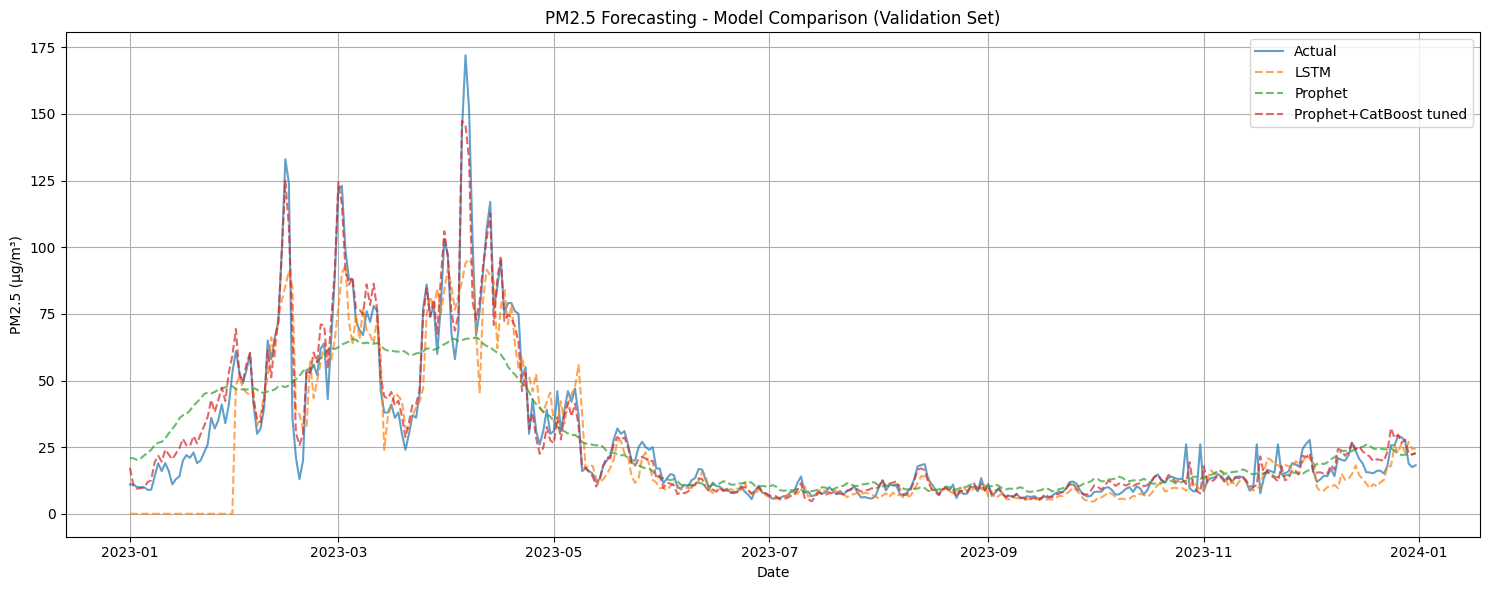

In [ ]:
val_dates = df_val.index

plt.figure(figsize=(15, 6))
plt.plot(val_dates, y_val, label='Actual', alpha=0.7)
plt.plot(val_dates[:len(np.concat([np.zeros((30, )), lstm_val_preds]))], np.concat([np.zeros((30, )), lstm_val_preds]), label='LSTM', linestyle='--', alpha=0.7)
plt.plot(val_dates, prophet_val_preds, label='Prophet', linestyle='--', alpha=0.7)
plt.plot(val_dates, hybrid_val_preds_opt, label='Prophet+CatBoost tuned', linestyle='--', alpha=0.7)
plt.title('PM2.5 Forecasting - Model Comparison (Validation Set)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

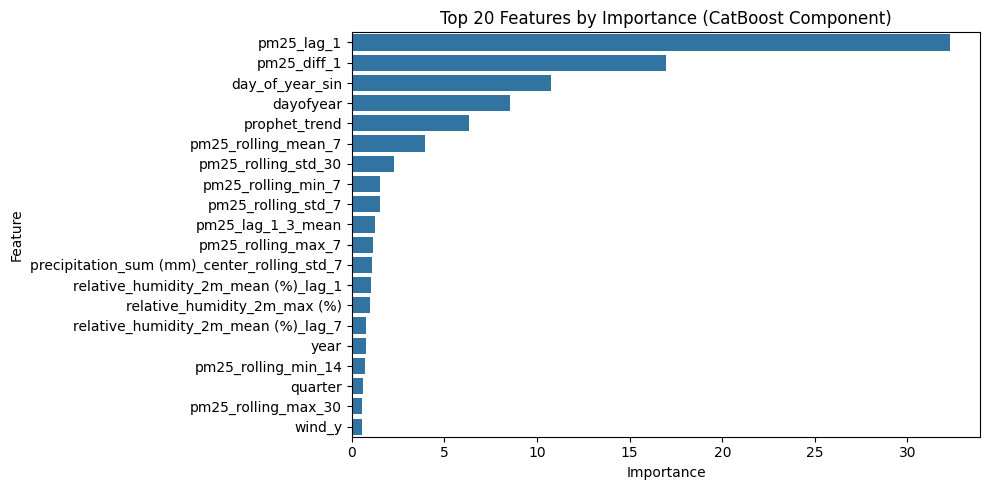

In [180]:
feature_importance = pd.DataFrame({
    'Feature': X_train_boost.columns,
    'Importance': optimized_cat.feature_importances_
})
feature_importance = feature_importance[~feature_importance['Feature'].str.startswith('fire')] # drop fire features
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 20 Features by Importance (CatBoost Component)')
plt.tight_layout()
plt.show()

In [184]:
important_feature_names = feature_importance['Feature'].tolist()

# Re-train with important_features

In [329]:
df_features_with_prophet_impt = df_features_with_prophet[important_feature_names + ['prophet_residuals', 'prophet_pred']]

In [330]:
df_train_with_prophet_impt = df_features_with_prophet_impt[:train_end]
df_val_with_prophet_impt = df_features_with_prophet_impt[train_end:val_end].drop(['2022-12-31'])
df_test_with_prophet_impt = df_features_with_prophet_impt[val_end:].drop(['2023-12-31'])

In [331]:
drop_cols_boost = ['prophet_residuals', 'prophet_pred']

X_train_boost, y_train_boost = create_X_y(df_train_with_prophet_impt, target_col='prophet_residuals', drop_cols=drop_cols_boost)
X_val_boost, y_val_boost = create_X_y(df_val_with_prophet_impt, target_col='prophet_residuals', drop_cols=drop_cols_boost)
X_test_boost, y_test_boost = create_X_y(df_test_with_prophet_impt, target_col='prophet_residuals', drop_cols=drop_cols_boost)

In [332]:
catboost_model = CatBoostRegressor(
    random_seed=42,
    verbose=False
)

catboost_model.fit(
    X_train_boost, y_train_boost,
    eval_set=[(X_val_boost, y_val_boost)],
    # cat_features=['season'],
    verbose=False
)

In [372]:
prophet_val_preds = df_val_with_prophet_impt['prophet_pred'].values
prophet_test_preds = df_test_with_prophet_impt['prophet_pred'].values

catboost_val_residual_preds = catboost_model.predict(X_val_boost)
hybrid_cat_preds = prophet_val_preds + catboost_val_residual_preds

In [334]:
hybrid_cat_rmse = np.sqrt(mean_squared_error(y_val, hybrid_cat_preds))
hybrid_cat_mape = mean_absolute_percentage_error(y_val, hybrid_cat_preds) * 100

print(f"Prophet + CatBoost RMSE: {hybrid_cat_rmse:.2f}, MAPE: {hybrid_cat_mape:.2f}%")

Prophet + CatBoost RMSE: 5.83, MAPE: 16.38%


In [335]:
cat_base = CatBoostRegressor(
    random_state=42,
    early_stopping_rounds=50,
    verbose=False
)

search_cat = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=param_grid_cat,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search_cat.fit(X_train_boost, y_train_boost)
print(f"Best parameters: {search_cat.best_params_}")
print(f"Best score: {-search_cat.best_score_:.4f} (MSE)")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 3, 'colsample_bylevel': 0.7}
Best score: 80.8801 (MSE)


In [373]:
optimized_cat = CatBoostRegressor(**search_cat.best_params_, random_state=42)
optimized_cat.fit(X_train_boost, y_train_boost, verbose=False)

# Make predictions with optimized model
cat_val_residual_preds_opt = optimized_cat.predict(X_val_boost)
cat_test_residual_preds_opt = optimized_cat.predict(X_test_boost)

hybrid_val_preds_opt = prophet_val_preds + cat_val_residual_preds_opt
hybrid_test_preds_opt = prophet_test_preds + cat_test_residual_preds_opt

In [374]:
hybrid_cat_rmse_opt = np.sqrt(mean_squared_error(y_val, hybrid_val_preds_opt))
hybrid_cat_mape_opt = mean_absolute_percentage_error(y_val, hybrid_val_preds_opt) * 100

print(f"Prophet + CatBoost RMSE: {hybrid_cat_rmse_opt:.2f}, MAPE: {hybrid_cat_mape_opt:.2f}%")

Prophet + CatBoost RMSE: 4.38, MAPE: 16.23%


# Evaluate Performances

## Multi-Horizon Evaluation

In [344]:
def evaluate_hybrid_model_horizons(horizons):
    results = []

    for horizon in horizons:
        preds = []
        actuals = []

        for i in range(len(df_val) - horizon):
            prophet_pred = df_val_with_prophet_impt['prophet_pred'].iloc[i + horizon]
            residual_pred = optimized_cat.predict(X_val_boost.iloc[i:i+1])[0]
            combined_pred = prophet_pred + residual_pred
            actual_value = df_val['pm25'].iloc[i + horizon]

            preds.append(combined_pred)
            actuals.append(actual_value)

        results.append({
            'Horizon': f'{horizon} days',
            'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
            'MAE': mean_absolute_error(actuals, preds),
            'MAPE': mean_absolute_percentage_error(actuals, preds) * 100
        })

    return pd.DataFrame(results)

In [347]:
forecast_horizons = [0, 1, 3, 7, 14, 30]

horizon_results = evaluate_hybrid_model_horizons(forecast_horizons)
print("Multi-Horizon Evaluation Results:")
print(horizon_results)

Multi-Horizon Evaluation Results:
   Horizon       RMSE        MAE       MAPE
0   0 days   4.378460   3.003363  16.228456
1   1 days  10.259025   5.583726  22.576171
2   3 days  18.173180   9.211636  33.407551
3   7 days  19.088373  11.152003  38.640198
4  14 days  21.183073  11.704857  38.837607
5  30 days  21.877468  12.360181  44.630862


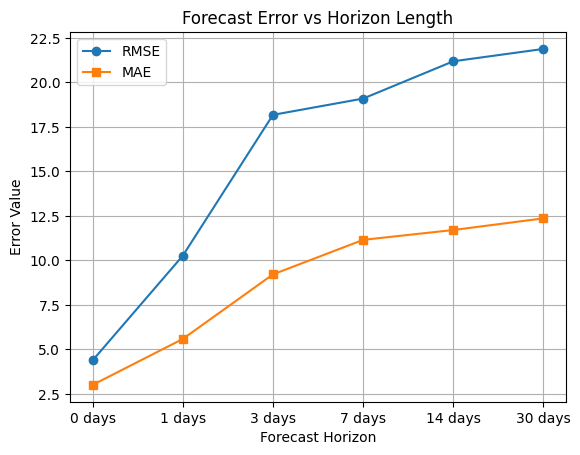

In [348]:
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='o', label='RMSE')
plt.plot(horizon_results['Horizon'], horizon_results['MAE'], marker='s', label='MAE')
plt.title('Forecast Error vs Horizon Length')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Value')
plt.grid(True)
plt.legend()
plt.show()

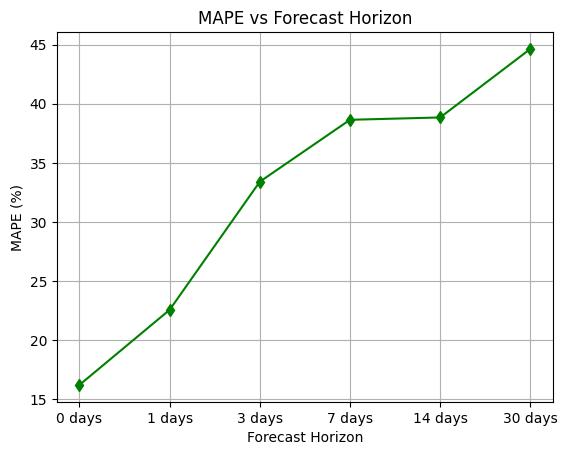

In [349]:
plt.plot(horizon_results['Horizon'], horizon_results['MAPE'], marker='d', color='green')
plt.title('MAPE vs Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

# Finalize Model

In [353]:
df_train_final_with_prophet = df_features_with_prophet_impt[:val_end].drop(['2023-12-31'])
drop_cols_boost = ['prophet_residuals', 'prophet_pred']
X_train_final_boost, y_train_final_boost = create_X_y(df_train_final_with_prophet, target_col='prophet_residuals', drop_cols=drop_cols_boost)

final_cat = CatBoostRegressor(**search_cat.best_params_, random_state=42)
final_cat.fit(X_train_final_boost, y_train_final_boost, verbose=False)

# Evaluation on Test Set

## Standard metrics

In [362]:
prophet_test_preds = df_test_with_prophet_impt['prophet_pred'].values

boost_test_residual_preds = final_cat.predict(X_test_boost)
hybrid_test_preds = prophet_test_preds + boost_test_residual_preds

In [363]:
hybrid_test_rmse = np.sqrt(mean_squared_error(y_test.drop(['2023-12-31']), hybrid_test_preds))
hybrid_test_mae = mean_absolute_error(y_test.drop(['2023-12-31']), hybrid_test_preds)
hybrid_test_mape = mean_absolute_percentage_error(y_test.drop(['2023-12-31']), hybrid_test_preds) * 100

In [364]:
print("\nFinal Hybrid Model Performance (Test Set):")
print(f"RMSE: {hybrid_test_rmse:.2f}")
print(f"MAE: {hybrid_test_mae:.2f}")
print(f"MAPE: {hybrid_test_mape:.2f}%")


Final Hybrid Model Performance (Test Set):
RMSE: 2.81
MAE: 2.03
MAPE: 11.12%


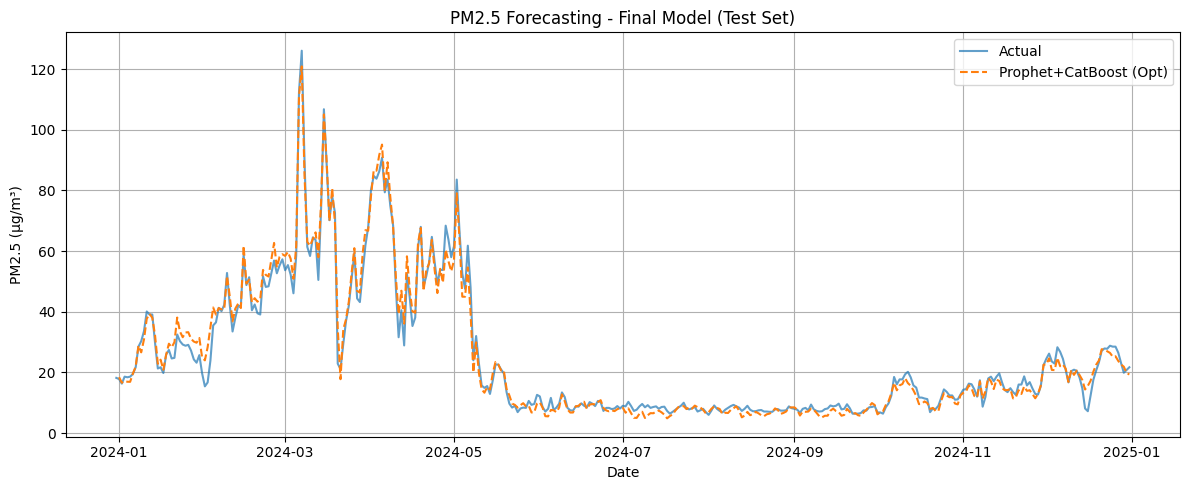

In [366]:
plt.figure(figsize=(12, 5))
plt.plot(df_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(df_test.drop(['2023-12-31']).index, hybrid_test_preds, label='Prophet+CatBoost (Opt)', linestyle='--')
plt.title('PM2.5 Forecasting - Final Model (Test Set)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Critical Periods (March)

In [375]:
march_mask = df_test.drop(['2023-12-31']).index.month == 3
test_march = df_test.drop(['2023-12-31'])[march_mask]
y_test_march = y_test.drop(['2023-12-31'])[march_mask]

In [378]:
prophet_test_march_preds = prophet_test_preds[march_mask]
hybrid_test_march_preds = hybrid_test_preds_opt[march_mask]
lstm_test_march_preds = lstm_test_preds[np.where(march_mask[:len(lstm_val_preds)])[0]]

In [379]:
march_metrics = pd.DataFrame({
    'Model': ['LSTM', 'Prophet', 'Hybrid'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_march[:len(lstm_test_march_preds)], lstm_test_march_preds)),
        np.sqrt(mean_squared_error(y_test_march, prophet_test_march_preds)),
        np.sqrt(mean_squared_error(y_test_march, hybrid_test_march_preds))
    ],
    'MAE': [
        mean_absolute_error(y_test_march[:len(lstm_test_march_preds)], lstm_test_march_preds),
        mean_absolute_error(y_test_march, prophet_test_march_preds),
        mean_absolute_error(y_test_march, hybrid_test_march_preds)
    ],
    'MAPE': [
        mean_absolute_percentage_error(y_test_march[:len(lstm_test_march_preds)], lstm_test_march_preds) * 100,
        mean_absolute_percentage_error(y_test_march, prophet_test_march_preds) * 100,
        mean_absolute_percentage_error(y_test_march, hybrid_test_march_preds) * 100
    ]
})

In [380]:
print("\nModel Performance in Critical Period (March, Test Set):")
print(march_metrics.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


Model Performance in Critical Period (March, Test Set):
  Model  RMSE   MAE  MAPE
   LSTM 22.74 16.99 31.64
Prophet 23.19 17.58 34.93
 Hybrid  4.17  3.49  7.32


## Multi-Horizon Evaluation

In [385]:
def evaluate_hybrid_model_horizons(horizons):
   results = []

   for horizon in horizons:
       preds = []
       actuals = []

       max_index = len(df_test) - horizon - 1

       if max_index < 0:
           results.append({
               'Horizon': f'{horizon} days',
               'RMSE': None,
               'MAE': None,
               'MAPE': None
           })
           continue

       for i in range(max_index + 1):
           try:
               if i + horizon < len(df_test_with_prophet_impt):
                   prophet_pred = df_test_with_prophet_impt['prophet_pred'].iloc[i + horizon]
                   residual_pred = optimized_cat.predict(X_test_boost.iloc[i:i+1])[0]
                   combined_pred = prophet_pred + residual_pred
                   actual_value = df_test['pm25'].iloc[i + horizon]

                   preds.append(combined_pred)
                   actuals.append(actual_value)
           except IndexError:
               continue

       if len(actuals) > 0:
           results.append({
               'Horizon': f'{horizon} days',
               'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
               'MAE': mean_absolute_error(actuals, preds),
               'MAPE': mean_absolute_percentage_error(actuals, preds) * 100
           })
       else:
           results.append({
               'Horizon': f'{horizon} days',
               'RMSE': None,
               'MAE': None,
               'MAPE': None
           })

   return pd.DataFrame(results)

In [386]:
forecast_horizons = [7, 15, 30, 90]

horizon_results = evaluate_hybrid_model_horizons(forecast_horizons)
print("Multi-Horizon Evaluation Results:")
print(horizon_results)

Multi-Horizon Evaluation Results:
   Horizon       RMSE        MAE       MAPE
0   7 days  14.881736   8.591836  34.524127
1  15 days  16.892609   9.866525  40.466403
2  30 days  14.078009   8.784679  42.945319
3  90 days  15.848094  10.280498  77.531709


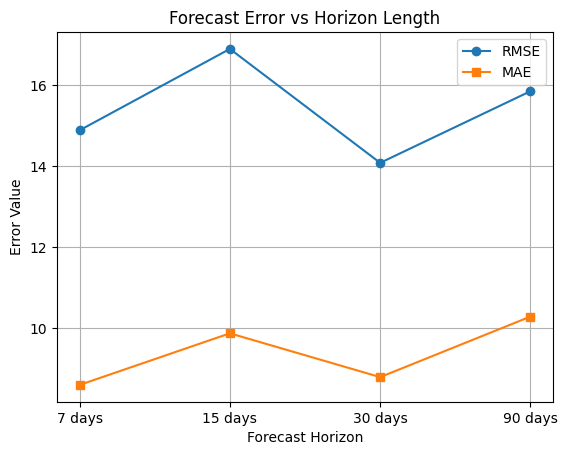

In [387]:
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='o', label='RMSE')
plt.plot(horizon_results['Horizon'], horizon_results['MAE'], marker='s', label='MAE')
plt.title('Forecast Error vs Horizon Length')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Value')
plt.grid(True)
plt.legend()
plt.show()

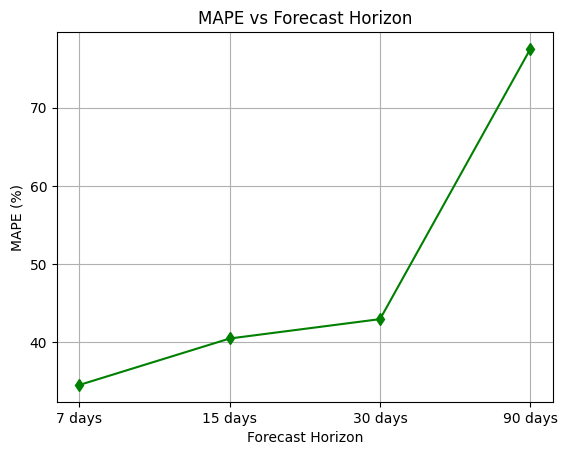

In [388]:
plt.plot(horizon_results['Horizon'], horizon_results['MAPE'], marker='d', color='green')
plt.title('MAPE vs Forecast Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

## Threshold-Based Metrics (Critical Level Detection)

In [391]:
threshold = 35 # Define PM2.5 critical threshold (35 μg/m³)

y_test_class = (y_test.drop(['2023-12-31']) > threshold).astype(int)
hybrid_test_class = (hybrid_test_preds > threshold).astype(int)

In [392]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score

test_cm = confusion_matrix(y_test_class, hybrid_test_class)
test_f2 = fbeta_score(y_test_class, hybrid_test_class, beta=2)
test_precision = precision_score(y_test_class, hybrid_test_class)
test_recall = recall_score(y_test_class, hybrid_test_class)

print("\nCritical Level Detection (PM2.5 35 μg/m³) Performance (Test Set):")
print(f"F2 Score: {test_f2:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("\nConfusion Matrix:")
print(test_cm)


Critical Level Detection (PM2.5 35 μg/m³) Performance (Test Set):
F2 Score: 0.9913
Precision: 0.9579
Recall: 1.0000

Confusion Matrix:
[[271   4]
 [  0  91]]


# Save model

In [395]:
station_id = '39T' # Station ID ⚠️ อย่าลืมเปลี่ยนด้วยนะ!

with open(f'prophet_model_{station_id}.json', 'w') as f:
    f.write(model_to_json(prophet_model))

optimized_cat.save_model(f'residual_model_{station_id}.cbm')

joblib.dump(scaler, f'scaler_{station_id}.pkl')

with open(f'selected_features_{station_id}.pkl', 'wb') as f:
    pickle.dump(selected_features, f)